In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Datasets/BIOSCAN
!ls

/content/drive/My Drive/Datasets/BIOSCAN
Bioscan.ipynb	    medium_training.tsv    __pycache__		  unseen.tsv
Bioscan_Test.ipynb  model_checkpoints	   small_training.tsv
full_training.tsv   model_checkpoints_new  transformers_utils.py


In [3]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=c266b965b703bb53877bcbf5efa327203bcc2e33e29ffdb510d5b42534965b51
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=9e7adf061959fe45930a5683c239a47b18909e823877d4a39cc827b0567dd325
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


In [4]:
# Load the libraries
from transformers_utils import BERT, SampleDNAData
from torch.utils.data import DataLoader
import pandas as pd
import umap
import torch
import numpy 
import matplotlib.pyplot as plt 




In [5]:
from transformers_utils import PabloDNADataset, tokenizer

def get_all_kmers(k_mer_length, alphabet=None) -> list:

  def base_convert(num, base, length):
      result = []
      while num > 0:
          result.insert(0, num % base)
          num = num // base
      while len(result) < length:
          result.insert(0, 0)
      return result

  if alphabet is None:
      alphabet = ["A", "C", "G", "T", "-", "N"]
  k_mer_counts = len(alphabet) ** k_mer_length
  all_k_mers_list = []
  for i in range(k_mer_counts):
      code = base_convert(num=i, base=len(alphabet), length=k_mer_length)
      k_mer = ""
      for j in range(k_mer_length):
          k_mer += alphabet[code[j]]
      all_k_mers_list.append(k_mer)

  return all_k_mers_list


test_path = "unseen.tsv"
test_dataset = PabloDNADataset(test_path)


# Remove X,R,Y letters from data
test_dataset.change_RXY2N("nucleotides")
test_nucleotides = list(test_dataset.df["nucleotides"].values)
test_species = list(test_dataset.df["species_name"].values)

word_list = get_all_kmers(4)
word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
for i, w in enumerate(word_list):
    word_dict[w] = i + 4
    number_dict = {i: w for i, w in enumerate(word_dict)}


In [6]:
# DNABERT configuration
config = {
    "d_model": 768,
    "n_heads": 12,
    "n_layers": 12,
    "max_len":512
}

model = BERT(len(word_dict), config["d_model"], config['max_len'], 2, config["n_layers"], 32, 32, config["n_heads"])

#Load the last model available from training
saving_path = "/content/drive/My Drive/Datasets/BIOSCAN/model_checkpoints_new/"
last_epoch = 50

model.load_state_dict(torch.load(saving_path + f'model_{last_epoch}.pth'))

<All keys matched successfully>

## Embedding - GAP

In [20]:
# This is not the most efficient way to do this - We should have a batch and
# a dataloader for testing. Sorry for now :(
embedding = []
for seq in test_nucleotides[:50]:
  tokens = tokenizer(seq, word_dict, 4, stride=1)
  input_ids = [word_dict['[CLS]']] + tokens + [word_dict['[SEP]']]
  segment_ids = [0] * (1 + len(tokens) ) + [1] * (1)
  masked_tokens, masked_pos = [], [] #No mask for testing
            
  # Zero Paddings
  n_pad = config['max_len'] - len(input_ids)
  input_ids.extend([0] * n_pad)
  segment_ids.extend([0] * n_pad)
  ids, seg, msk_pos = torch.Tensor(input_ids).type(torch.IntTensor), torch.Tensor(segment_ids).type(torch.IntTensor), torch.Tensor(masked_pos).type(torch.int64)
  #ids, seg, msk_pos = torch.cuda.IntTensor(input_ids), torch.cuda.IntTensor(segment_ids), torch.cuda.LongTensor(masked_pos)



  with torch.no_grad():
    out = model(ids.unsqueeze(1), seg.unsqueeze(1), msk_pos.unsqueeze(1))
    z = torch.squeeze(torch.mean(out[-1], 0,False)).cpu().numpy()
    embedding.append(z)  #GAP to compute the hidden representations
print(len(embedding))

50


(50, 768)
(50, 2)


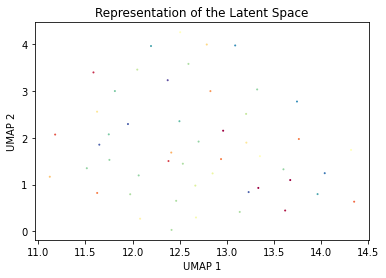

In [21]:
import numpy as np
latent = np.array(embedding)
print(latent.shape)
unique_labels = list(np.unique(test_species[:50]))
y_true = np.array(list(map(lambda x: unique_labels.index(x), test_species[:50])))

fig, ax = plt.subplots(nrows=1, ncols=1) 
ax.set_title("Representation of the Latent Space")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

_embedding = umap.UMAP(random_state=42).fit_transform(latent)
print(_embedding.shape)

ax.scatter(_embedding[:, 0],
           _embedding[:, 1],
           c=y_true,
           s=1,
           cmap='Spectral')
plt.show()



## Embedding - ['CLS']

## Embedding - MAP
